# [LAB 12] 2. 회귀분석의 가정 검정

통계학에서의 회귀 분석은 전제 조건이 생각보다 까다로운 편이며 사실 이 전제 조건들이 참이어야만 회귀분석을 통해 얻은 결괏값과 의미가 비로소 참이라고 할 수 있따

- 종속변수의 값은 정규성을 지녀야 한다
- 독립변수 간에는 다중 공선성이 존재하지 않는다
- 선형 회귀 분석의 경우, 독립변수와 종속변수 간의 선형성이 보장되어야 한다
- 오차항은 독립변수의 값과 관계없이 동일한 분산을 가지며, 기댓값은 0이다

이런 전제조건이 만족한징 아닌지는 회귀 분석으로 추정된 회귀식을만들고 난 뒤 여러가지 회귀 분석 적합성 검정을 통해 확인할 수 있다


| 조건           | 설명                                            |
| ------------ | --------------------------------------------- |
| **잔차의 선형성**  | 종속·독립변수의 관계가 선형이다. (가장 중요한 가정) → 잔차를 통해 확인한다. |
| **잔차의 정규성**  | 오차의 분포가 정규분포를 따른다.                            |
| **잔차의 등분산성** | 오차의 분산이 입력변수와 무관하게 일정하다.                      |
| **잔차의 독립성**  | 입력변수와 오차는 관련이 없다.                             |


### #01.준비작업
#### 1.패키지 참조

In [1]:
# 라이브러리 기본 참조
from hossam import load_data
from pandas import DataFrame, melt
from matplotlib import pyplot as plt
from matplotlib import font_manager as fm
import seaborn as sb
import numpy as np


# 선형회귀를 위한 참조
import statsmodels.api as sm
from statsmodels.formula.api import ols


# 결과 검정을 위한 참조
from statsmodels.stats.diagnostic import linear_reset
from scipy.stats import zscore, probplot, shapiro, kstest
from statsmodels.stats.api import het_breuschpagan
from statsmodels.stats.stattools import durbin_watson

#### 2.그래프 초기화

In [2]:
#한글을 지원하는 폰트 파일의 경로
font_path ='C:\\Data_Analysis_Basic\\[LAB-06] 데이터 시각화 개요\\NotoSansKR-Regular.ttf'
#폰트의 그룹을 시스템에 등록
fm.fontManager.addfont(font_path)
#폰트의 속성을 읽어옴
font_prop = fm.FontProperties(fname=font_path)
#읽어온 속성에서 폰트의 이름만 추출
font_name = font_prop.get_name()

#이미지의 선명도를 결정 (1인치 당 픽셀의 수)
my_dpi = 120 
#시스템에 등록된 글꼴 이름  (상단에서 확인한 폰트 이름으로 넣기)
my_font_name = 'Noto Sans KR'
#그림 스타일 지정
my_theme = 'dark'
#seaborn 스타일 (화풍 설정하기)
sb.set_theme(style=my_theme)
#그래프에 한글 폰트 적용
plt.rcParams['font.family']=my_font_name
#기본 폰트 크기
plt.rcParams['font.size'] =16
#그래프에 마이너스 꺠짐 방지 (한글환경에서 필수)
plt.rcParams['axes.unicode_minus']=False

#### 3. 데이터 가져오기

In [3]:
origin = load_data('cars')
origin.head()

[data] https://data.hossam.kr/data/lab12_/cars.xlsx
[desc] 자동차의 속도(speed)에 따른 제동거리(dist) 조사 데이터 (출처: R 기본 데이터)

field    description
-------  -------------
speed    속도
dist     제동거리



,speed,dist
0,4,2
1,4,10
2,7,4
3,7,22
4,8,16


### #02. 단순선형회귀

In [6]:
yname = 'dist'


x=origin.drop(yname,axis =1)
y=origin[yname]
X=sm.add_constant(x)


fit = sm.OLS(y,X).fit()
print(fit.summary())

                            OLS Regression Results                            
Dep. Variable:                   dist   R-squared:                       0.651
Model:                            OLS   Adj. R-squared:                  0.644
Method:                 Least Squares   F-statistic:                     89.57
Date:                Thu, 11 Dec 2025   Prob (F-statistic):           1.49e-12
Time:                        15:36:57   Log-Likelihood:                -206.58
No. Observations:                  50   AIC:                             417.2
Df Residuals:                      48   BIC:                             421.0
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const        -17.5791      6.758     -2.601      0.0

### #03. 잔차분석
회귀분석의 가정은 잔차를 통해 이루어지기 때문에 잔차분석이라고 부르기도 한다

#### 1.잔차 구하기
예측값 구하기

In [7]:
y_pred = fit.predict(X)
y_pred.head()

0    -1.849460
1    -1.849460
2     9.947766
3     9.947766
4    13.880175
dtype: float64

- 회귀분석 결과 객체 안에 내장되어 있는 예측값
- predict() 메서드에 전달되는 파라미터가 분석에 사용된 데이터와 동일하다면 내장되어 있는 값을 사용해도 동일하다

- predict() 메서드는 수집된 샘플 이외에 새로운 입력값에 대한 예측치를 얻고자 할 경우 사용

In [8]:
y_pred = fit.fittedvalues
y_pred.head()

0    -1.849460
1    -1.849460
2     9.947766
3     9.947766
4    13.880175
dtype: float64

- 잔차 - 직접 구하기
실제 종석변수에서 예측치를 뺸다

In [9]:
residual = origin['dist'] - y_pred
residual.head()

0     3.849460
1    11.849460
2    -5.947766
3    12.052234
4     2.119825
dtype: float64

- 회귀분석 결과에 내장된 잔차값

In [10]:
residual = fit.resid
residual.head()

0     3.849460
1    11.849460
2    -5.947766
3    12.052234
4     2.119825
dtype: float64

- 분석 데이터에 결합


In [11]:
df = origin.copy()
df['y_pred'] = y_pred
df['resid'] = residual
df.head()

,speed,dist,y_pred,resid
0,4,2,-1.849460,3.849460
1,4,10,-1.849460,11.849460
2,7,4,9.947766,-5.947766
3,7,22,9.947766,12.052234
4,8,16,13.880175,2.119825


#### 2.잔차의 선형성 검정
- 시각화를 통한 검정
  예측값에 따른 잔차에 대한 산점도 + 추세선 그래프를 그린다
  모든 예측값에서 가운데 점선에 맞추어 잔차가 비슷하게 있어야 한다.
  빨간 실선은 잔차의 추세를 의미. 빨간 실선이 점선에서 크게 벗어난다면 잔차가 크게 달라진다는 의미이므로 선형성이 없다는 것이다

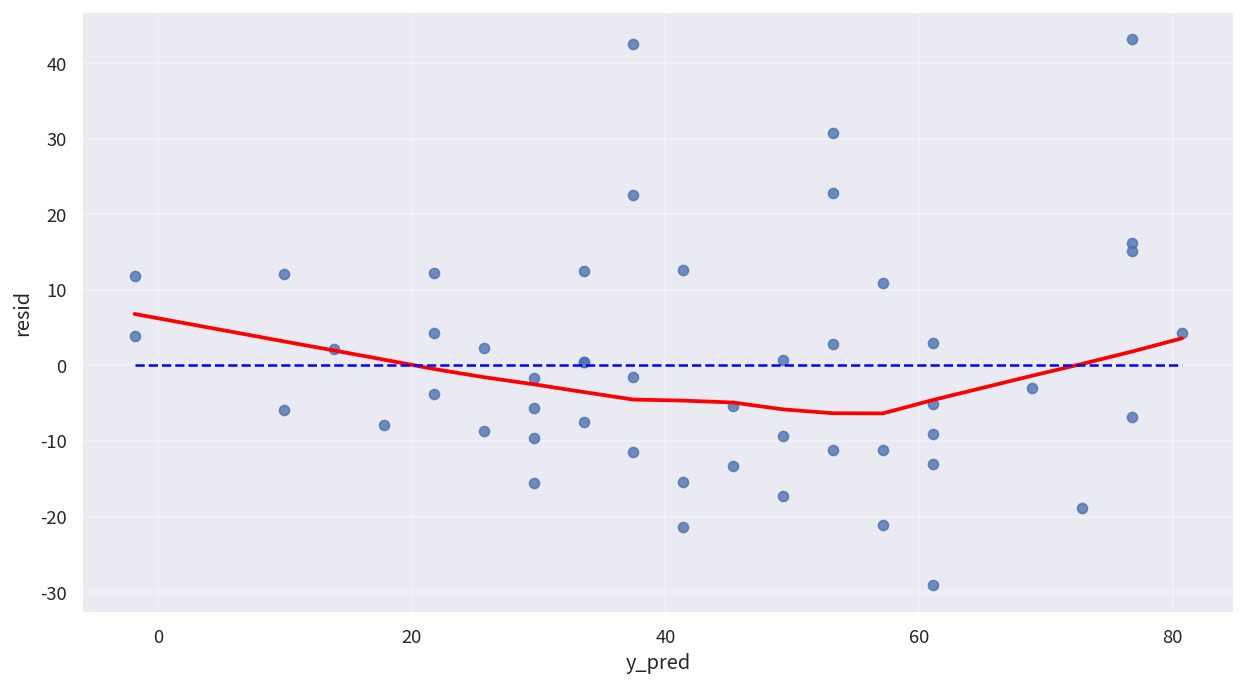

In [13]:
xmin = df['y_pred'].min()
xmax = df['y_pred'].max()
xrange = [xmin, xmax]
yrange = [0, 0]
# 1) 그래프 초기화
width_px  = 1280
height_px = 720
# 그래프 가로 크기
# 그래프 세로 크기
rows = 1
cols = 1
# 그래프 행 수
# 그래프 열 수
figsize = (width_px / my_dpi, height_px / my_dpi)
fig, ax = plt.subplots(rows, cols, figsize=figsize, dpi=my_dpi)
# 2) regplot 그리기
sb.regplot(data=df, x='y_pred', y='resid', lowess=True, line_kws={'color': 'red'})

sb.lineplot(x=xrange, y=yrange, color='blue', linestyle='--')


# 3) 그래프 꾸미기
ax.grid(True, alpha=0.3)           
# 배경 격자 표시
# 4) 출력
plt.tight_layout()      
plt.show()              
# 여백 제거
# 그래프 화면 출력
plt.close()             
# 그래프 작업 종료


- 통계량을 위한 검정 - Ramsey RESET TEST

In [15]:
reset_res = linear_reset(fit, power=2, use_f=True)
print(f"RESET F-statistic: {reset_res.fvalue:.4f}")
print(f"p-value: {reset_res.pvalue:.4f}")

if reset_res.pvalue < 0.05:
  print("선형성/기능형 위배 가능성이 있음 (5% 유의수준)")
else:
  print("선형성 가정 위배 근거 없음 (5% 유의수준)")

RESET F-statistic: 2.2960
p-value: 0.1364
선형성 가정 위배 근거 없음 (5% 유의수준)


### 3. 잔차의 정규성
- 잔차가 정규분포를 따르는지를 확인

- 시각화를 통한 검정
  구해놓은 예측값을 활용하여 ZSCORE 값을 구한다
  ZSCORE 를 시각화 한 QQPLOT 으로 확인. 잔차가 정규분포에 따르면 QQ PLOT 에서 점들이 점선을 따라 배치된다

- ZSCORE 구하기

In [16]:
df['zscore'] = zscore(df['y_pred'])
df.head()

,speed,dist,y_pred,resid,zscore
0,4,2,-1.849460,3.849460,-2.177858
1,4,10,-1.849460,11.849460,-2.177858
2,7,4,9.947766,-5.947766,-1.604738
3,7,22,9.947766,12.052234,-1.604738
4,8,16,13.880175,2.119825,-1.413697


- Q Q 플롯의 좌표 구하기

In [17]:
(x, y), _ = probplot(df['zscore'])
display(x[:5])
display(y[:5])

array([-2.20385432, -1.83293478, -1.61402323, -1.45296849, -1.32267759])

array([-2.17785805, -2.17785805, -1.60473751, -1.60473751, -1.41369733])

- Q Q 플롯 그리기
  ZSCORE 에 대한 산점도 그래프

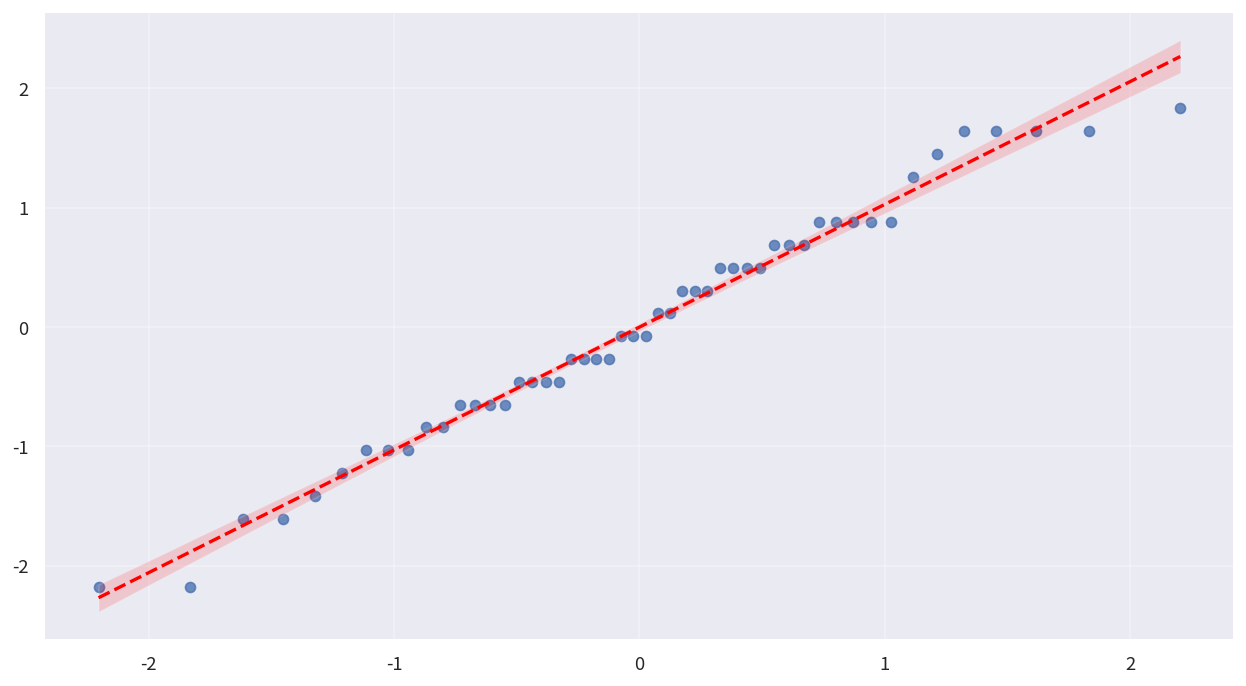

In [19]:
# 1) 그래프 초기화
width_px  = 1280
height_px = 720
# 그래프 가로 크기
# 그래프 세로 크기
rows = 1
# 그래프 행 수
cols = 1
# 그래프 열 수
figsize = (width_px / my_dpi, height_px / my_dpi)
fig, ax = plt.subplots(rows, cols, figsize=figsize, dpi=my_dpi)
# 2) regplot 그리기

sb.regplot(x=x, y=y, line_kws={
"color": "red",
"linestyle": "--",   
"linewidth": 2
            })
# 3) 그래프 꾸미기
ax.grid(True, alpha=0.3)           
# 점선
# 배경 격자 표시
# 4) 출력
plt.tight_layout()      
plt.show()              
# 여백 제거
# 그래프 화면 출력
plt.close()             
# 그래프 작업 종료

- 잔차도를 통한 검정
- 잔차의 분산인 MSE 를 통해 검정한다
- 잔차가 정규분포를 따른다면 대략적으로
 

  - $\pm\sqrt{MSE}$ 범위 안에 최소 59% 의 잔차가 포함된다.
  - $\pm2\sqrt{MSE}$ 범위 안에 최소 68% 의 잔차가 포함된다.
  - $\pm3\sqrt{MSE}$ 범위 안에 최소 99% 의 잔차가 포함된다.

In [20]:
MSE_sq = np.sqrt(fit.mse_resid) # 잔차 분산의 제곱근
r = fit.resid   
# 잔차
r1 = r[ (r >-MSE_sq) & (r < MSE_sq)].count() / r.count() * 100
r2 = r[ (r >-2*MSE_sq) & (r < 2*MSE_sq)].count() / r.count() * 100
r3 = r[ (r >-3*MSE_sq) & (r < 3*MSE_sq)].count() / r.count() * 100


mse_r = [r1, r2, r3]
print(f"루트 1MSE 구간에 포함된 잔차 비율: {r1:.2f}%")
print(f"루트 2MSE 구간에 포함된 잔차 비율: {r2:.2f}%")
print(f"루트 3MSE 구간에 포함된 잔차 비율: {r3:.2f}%")

루트 1MSE 구간에 포함된 잔차 비율: 74.00%
루트 2MSE 구간에 포함된 잔차 비율: 94.00%
루트 3MSE 구간에 포함된 잔차 비율: 100.00%


- 잔차도 시각화
  예측값과 실제값간의 잔차를 RESIDPLOT 으로 시각화 한 그래프

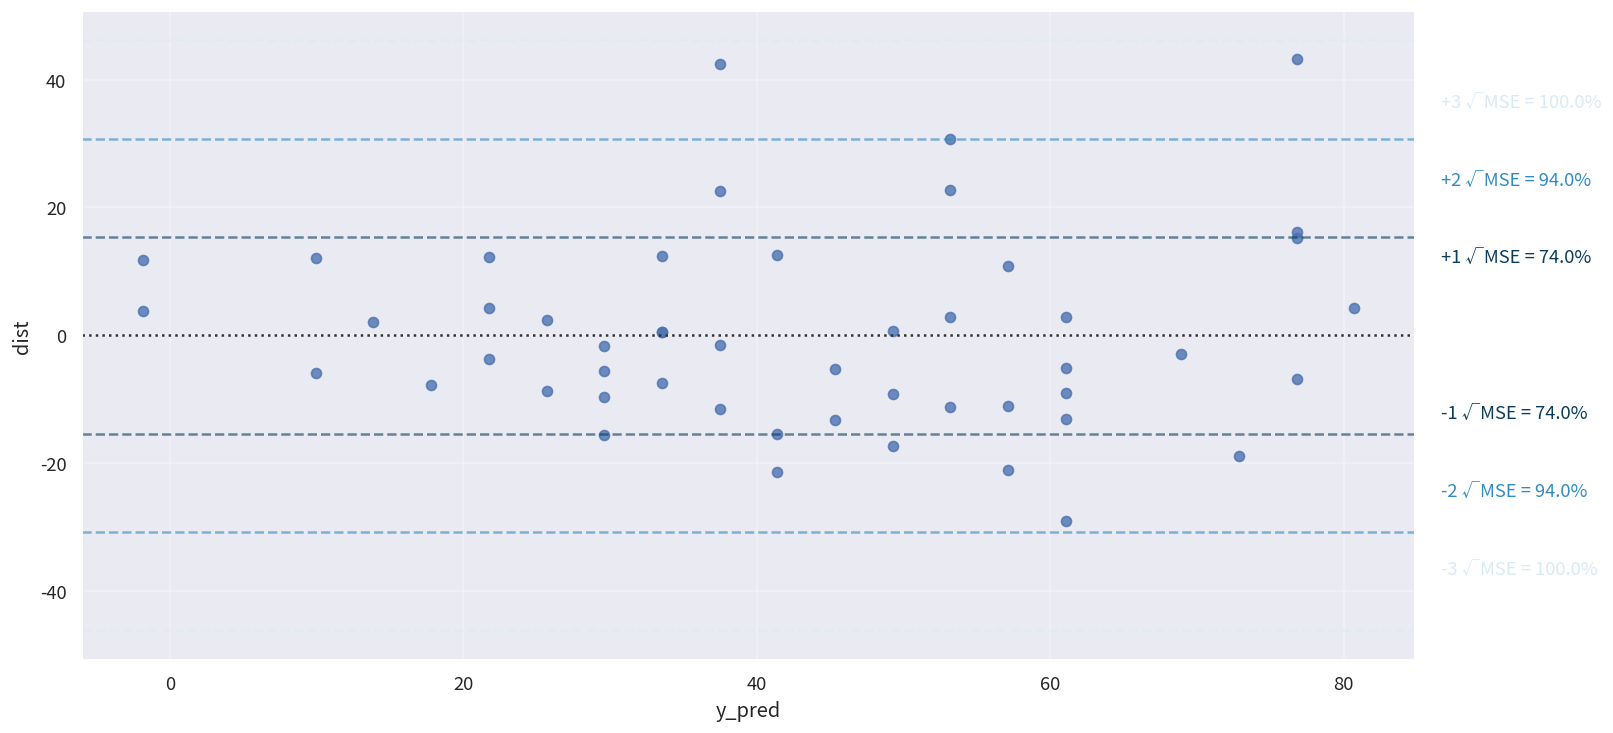

In [22]:
mse_sq = fit.mse_resid
mse_root = np.sqrt(mse_sq)
colors = ["#0B3C5D", "#328CC1", "#D9EAF7"]
xmax = df['y_pred'].max()
ymin = df['y_pred'].min()
# 1) 그래프 초기화
width_px  = 1600
height_px = 720
figsize = (width_px / my_dpi, height_px / my_dpi)
fig, ax = plt.subplots(1, 1, figsize=figsize, dpi=my_dpi, constrained_layout=True)
# 2) seaborn 기본 잔차도
sb.residplot(data=df, x='y_pred', y="dist", ax=ax)
# 3) 꾸미기
ax.grid(True, alpha=0.3)
# 4) MSE 3단계 표시
for i, c in enumerate(colors):
    k = i + 1
# 올바른 ±k√MSE 위치
    y_pos = k * mse_root
    ax.axhline(y= y_pos,  color=c, linestyle="--", alpha=0.6)
    ax.axhline(y=-y_pos,  color=c, linestyle="--", alpha=0.6)
# 텍스트는 축 좌표계 사용 (그래프 밖으로 안 나감)
    ax.text(x=1.02, y=0.5 + 0.12*k,
            s=f"+{k} √MSE = {mse_r[i]}%",
            transform=ax.transAxes,
            ha="left", va="center", fontsize=11, color=c)
    ax.text(x=1.02, y=0.5- 0.12*k,
            s=f"-{k} √MSE = {mse_r[i]}%",
    transform=ax.transAxes,
            ha="left", va="center", fontsize=11, color=c)
# 5) 출력
plt.show()
plt.close()

- 검정 통계량을 사용한 검정

| 통계량                       | 사용하는 경우             |
| ------------------------- | ------------------- |
| **Shapiro–Wilk 검정**       | 표본수가 **30개 미만**인 경우 |
| **Kolmogorov–Smirnov 검정** | 표본수가 **30개 이상**인 경우 |


  - 귀무가설 : 표본의 모집단이 정규분포를 따름
  - 대립가설 : 표본의 모집단이 정규분포를 따르지 않음

In [23]:
# 샘플 수에 따라 정규성 검정 선택
if len(origin) < 30:
    method = "Shapiro-Wilk"
    s, p = shapiro(df['resid'])
else:
    method = "Kolmogorov–Smirnov"
    mu = df['resid'].mean()
    sigma = df['resid'].std(ddof=1)
    s, p = kstest(df['resid'], 'norm', args=(mu, sigma))
# 결과 문자열
result = f"{method} Test //: statistic: {s:.3f}, p-value: {p:.3f}, {'대립' if p <=0.05 else '귀무'}가설 채택"


print(result)

Kolmogorov–Smirnov Test //: statistic: 0.130, p-value: 0.341, 귀무가설 채택


#### 4.잔차의 등분산성 - 브로이슈-패건 검정

| 가설       | 설명                                        |
| -------- | ----------------------------------------- |
| **귀무가설** | 등분산성 가정이 만족된다 (오차의 분산은 독립변수들과 관련이 없다)     |
| **대립가설** | 등분산성 가정이 만족되지 않는다 (오차의 분산은 독립변수들과 관련이 있다) |


중심극한 정리에 의해 표본수가 30보다 크면 무시해도 됨

In [25]:
# Breusch–Pagan Test
names = ['LM Statistic', 'LM p-value', 'F Statistic', 'F p-value']
bp_test = het_breuschpagan(fit.resid, fit.model.exog)
bp = DataFrame(bp_test, index=names, columns=['value'])
display(bp)
# p-value는 F p-value를 기준으로 사용
p_bp = bp.loc['F p-value', 'value']
# 출력문 생성
bp_result = (
f"Breusch–Pagan Test ::: "
  f"F = {bp.loc['F Statistic','value']:.3f}, "
  f"p-value = {p_bp:.3f}, "
  f"{'대립' if p_bp <= 0.05 else '귀무'}가설 채택 → "
  f"{'이분산성 존재(등분산 아님)' if p_bp <= 0.05 else '등분산성 만족'}"
  )
print(bp_result)

,value
LM Statistic,3.214880
LM p-value,0.072972
F Statistic,3.298361
F p-value,0.075597


Breusch–Pagan Test ::: F = 3.298, p-value = 0.076, 귀무가설 채택 → 등분산성 만족


#### 5.잔차의 독립성
회귀분석 결과표 하단의 Durbin-Watson 값을 확인한다

일반적으로 DW 값이 1.5 - 2.5 범위에 있으면 독립으로 판정 


| 수치            | 해석                                 |
| ------------- | ---------------------------------- |
| **1.5 ~ 2.5** | 독립성 문제 없음 (자가상관 없음을 의미)            |
| **< 1.5**     | 잔차들이 **양의 상관 관계** (독립성 X, 자가상관 의심) |
| **> 2.5**     | 잔차들이 **음의 상관 관계** (독립성 X, 자가상관 의심) |


durbin_watson(df['잔차'])의 리턴값으로 DW값을 얻을 수 있다
Durbin-Watson 검정은 원래 시계열 데이터 전용이기 때문에 독립성이 위배될 경우 무시해도 좋다

In [26]:
dw = durbin_watson(df['resid'])
if 1.5 <= dw <= 2.5:
    interpretation = "잔차는 독립성을 만족함 (자기상관 없음)"
elif dw < 1.5:
    interpretation = "잔차에 양(+)의 자기상관이 존재할 가능성 있음 (독립성 위반)"
else:
    interpretation = "잔차에 음(–)의 자기상관이 존재할 가능성 있음 (독립성 위반)"
print(f"Durbin–Watson = {dw:.3f} //: {interpretation}")

Durbin–Watson = 1.676 //: 잔차는 독립성을 만족함 (자기상관 없음)


### #04. 가정에 위배되면?
가정 하나라도 위반되면 회귀를 버리는 것이 아니라, 모형을 보정하거나 적절한 대안을 선택하는 것이 올바른 대응이다



| 위반된 가정     | 문제 의미            | 어떻게 확인하나?                 | 해결 방법                                                  |
| ---------- | ---------------- | ------------------------- | ------------------------------------------------------ |
| **선형성 위반** | X와 Y의 관계가 직선이 아님 | 잔차 vs 적합값 그래프에서 **곡선 패턴** | ① 변수 변환(log, sqrt 등) <br>② 다항항 추가(X²) — 선형회귀 안에서 해결 가능 |



| 위반된 가정     | 문제 의미                        | 어떻게 확인하나?              | 해결 방법                                                  |
| ---------- | ---------------------------- | ---------------------- | ------------------------------------------------------ |
| **정규성 위반** | 잔차가 정규분포 아님 → p-value 신뢰도 감소 | QQ-plot / Shapiro–Wilk | ① **Y 변환(log, sqrt)** <br>② 표본이 충분히 크면(n > 30) 큰 문제 아님 |



| 위반된 가정     | 문제 의미                     | 어떻게 확인하나?     | 해결 방법                                     |
| ---------- | ------------------------- | ------------- | ----------------------------------------- |
| **독립성 위반** | 잔차가 서로 상관됨 (특히 시간 흐름 데이터) | Durbin–Watson | ① 추세·시간 변수 추가 (예: t) <br>② 무시해도 되는 경우도 있음 |



| 위반된 가정      | 문제 의미                        | 어떻게 확인하나?                  | 해결 방법                                                           |
| ----------- | ---------------------------- | -------------------------- | --------------------------------------------------------------- |
| **등분산성 위반** | 잔차 분산이 일정하지 않음 → 회귀계수 해석 불안정 | 잔차 vs 적합값 그래프에서 **부채꼴 모양** | ① **Y 변환(log, sqrt)** → 가장 효과적 <br>② 표본이 충분히 크면(n > 30) 큰 문제 아님 |
